In [2]:
import skimage.io as io
import scipy.fft as fft
import cv2
from ffextractor import FeaturesLocator
import commonfunctions as cf
import numpy as np

In [3]:
locator = FeaturesLocator(load=True, path="./results")
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [11]:
import imutils

def check_left_eye(keypoint, w, h):
    x, y = keypoint
    return True


def check_right_eye(keypoint, w, h):
    x, y = keypoint
    return w // 2 < x and x < w and 2 * h // 7 < y and y < 4 * h // 7


def check_nose_eye(keypoint):
    pass


def check_mouth_eye(keypoint):
    pass

def angle_transform(pair, angle):
    x = pair[0] * np.cos(angle * np.pi / 180) - pair[1] * np.sin(angle * np.pi / 180)
    y = pair[0] * np.sin(angle * np.pi / 180) + pair[1] * np.cos(angle * np.pi / 180)
    pair[0] = x
    pair[1] = y
    return pair


def render_filter_0(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_grey, 1.3, 5)
    if len(faces) == 0:
        return img
    all_keypoints = []

    (y, x, h, w) = faces[0]
    face = img_grey[x : x + w, y : y + h]

    rots = [352, 354, 356, 358, 0, 2, 4, 6, 8]
    for rot in rots:
        face_rotated = imutils.rotate(face, -rot)
        keypoints = locator.findfeatures(face)
        for k,v in keypoints.items():
            keypoints[k] = angle_transform(v, rot)

        all_keypoints.append(keypoints)        


    keypoints = {}
    keypoints['left_eye'] = np.median(
        [x['left_eye'] for x in all_keypoints if check_left_eye(x['left_eye'], w, h)],
        axis=0
    ).astype(np.uint32)
    keypoints['right_eye'] = np.median(
        [x['right_eye'] for x in all_keypoints if check_right_eye(x['right_eye'], w, h)],
        axis=0
    ).astype(np.uint32)

    xwidth = int(9 * img.shape[0] / 350)
    ywidth = int(4 * img.shape[1] / 350)
    thickness = (img.shape[0] * img.shape[1]) // 200000
    cv2.ellipse(
        img,
        np.add(keypoints['left_eye'], [y, x]),
        (xwidth, ywidth),
        0,
        0,
        360,
        color=255,
        thickness=thickness,
    )
    cv2.ellipse(
        img,
        np.add(keypoints['right_eye'], [y, x]),
        (xwidth, ywidth),
        0,
        0,
        360,
        color=255,
        thickness=thickness,
    )
    # cv2.ellipse(
    #     img,
    #     np.add(keypoints['nose'], [y, x]),
    #     (xwidth, ywidth),
    #     0,
    #     0,
    #     360,
    #     color=255,
    #     thickness=thickness,
    # )
    # cv2.ellipse(
    #     img,
    #     np.add(keypoints['mouth'], [y, x]),
    #     (xwidth, ywidth),
    #     0,
    #     0,
    #     360,
    #     color=255,
    #     thickness=thickness,
    # )
    cv2.rectangle(img, (y, x), (y + h, x + w), (0, 0, 255), 2)
    return img

In [12]:
def render_filter_0_no_media(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_grey, 1.3, 5)
    if len(faces) == 0:
        return img
    (y, x, h, w) = faces[0]
    face = img_grey[x : x + w, y : y + h]       
    keypoints = locator.findfeatures(face)

    xwidth = int(9 * img.shape[0] / 350)
    ywidth = int(4 * img.shape[1] / 350)
    thickness = (img.shape[0] * img.shape[1]) // 200000
    cv2.ellipse(
        img,
        np.add(keypoints['left_eye'], [y, x]),
        (xwidth, ywidth),
        0,
        0,
        360,
        color=255,
        thickness=thickness,
    )
    cv2.ellipse(
        img,
        np.add(keypoints['right_eye'], [y, x]),
        (xwidth, ywidth),
        0,
        0,
        360,
        color=255,
        thickness=thickness,
    )
    cv2.ellipse(
        img,
        np.add(keypoints['nose'], [y, x]),
        (xwidth, ywidth),
        0,
        0,
        360,
        color=255,
        thickness=thickness,
    )
    cv2.ellipse(
        img,
        np.add(keypoints['mouth'], [y, x]),
        (xwidth, ywidth),
        0,
        0,
        360,
        color=255,
        thickness=thickness,
    )
    cv2.rectangle(img, (y, x), (y + h, x + w), (0, 0, 255), 2)
    return img

In [13]:
def add_transparent_image(background, foreground, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert (
        bg_channels == 3
    ), f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert (
        fg_channels == 4
    ), f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    x_offset = x_offset - foreground.shape[0] // 2
    y_offset = y_offset - foreground.shape[1] // 2
    # center by default
    if x_offset is None:
        x_offset = (bg_w - fg_w) // 2
    if y_offset is None:
        y_offset = (bg_h - fg_h) // 2

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1:
        return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y : fg_y + h, fg_x : fg_x + w]
    background_subsection = background[bg_y : bg_y + h, bg_x : bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = (
        background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask
    )

    # overwrite the section of the background image that has been updated
    background[bg_y : bg_y + h, bg_x : bg_x + w] = composite

In [14]:
def render_filter_1(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_grey, 1.3, 5)
    if len(faces) == 0:
        return img
    glasses = cv2.imread("./filters/glasses.png", cv2.IMREAD_UNCHANGED)
    (y, x, h, w) = faces[0]
    glasses = cv2.resize(glasses, (np.array([w, h]) * 0.8).astype(int))
    face = img_grey[x : x + w, y : y + h]
    keypoints = locator.findfeatures(face)
    center = (keypoints["left_eye"] + keypoints["right_eye"]) // 2
    add_transparent_image(img, glasses, center[0] + y, center[1] + x)
    return img


In [15]:
def render_filter_2(img):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img_grey, 1.3, 5)
    if len(faces) == 0:
        return img
    nose = cv2.imread("./filters/clown_nose.png", cv2.IMREAD_UNCHANGED)
    wig = cv2.imread("./filters/clown_wig.png", cv2.IMREAD_UNCHANGED)
    (y, x, h, w) = faces[0]
    nose = cv2.resize(nose, (np.array([w, h]) * 0.30).astype(int))
    wig = cv2.resize(wig, (np.array([w, h]) * 1.25).astype(int))
    face = img_grey[x : x + w, y : y + h]
    keypoints = locator.findfeatures(face)
    center_nose = keypoints["nose"]
    center_wig = (keypoints["left_eye"] + keypoints["right_eye"]) // 2
    add_transparent_image(img, nose, center_nose[0] + y, center_nose[1] + x)
    add_transparent_image(img, wig, center_wig[0] + y, center_wig[1] + x - h // 3)
    return img


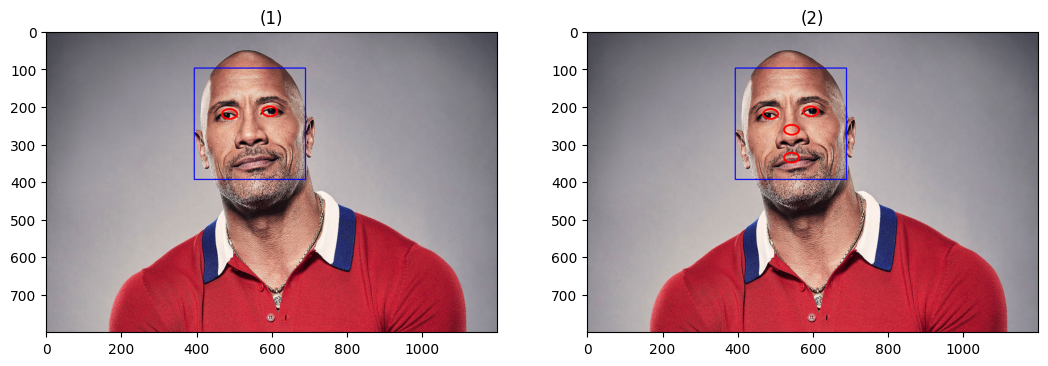

In [16]:
import imutils

img = io.imread(f"../rock.jpg")
render_filter_0(img)
img2 = io.imread(f"../rock.jpg")
render_filter_0_no_media(img2)
cf.show_images([img, img2])

In [10]:
# # live feed
# # define a video capture object
# vid = cv2.VideoCapture(0)

# while(True):

#     # Capture the video frame
#     # by frame
#     ret, frame = vid.read()
#     frame = render_features(frame)
#     # Display the resulting frame
#     cv2.imshow('frame', frame)

#     # the 'q' button is set as the
#     # quitting button you may use any
#     # desired button of your choice
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # After the loop release the cap object
# vid.release()
# # Destroy all the windows
# cv2.destroyAllWindows()
